In [31]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import FK5, SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from tqdm import tqdm

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
plt.rcParams['figure.figsize'] = [8, 8]

In [2]:
data = Table.read('SDSS_LAB2024_photometry.fits')

When computing the local environment it is common to define: A Primary galaxy (the one you are computing the local density for), the Neighbours sample (all the other galaxies that contribute to the environment metrics)

In [3]:
Nneigh = np.zeros_like(data['ra'])
AP_radius = 500 #kpc
DV_cut    = 1000 #km/s

NEIcoords = SkyCoord(ra=data['ra']*u.deg, dec=data['dec']*u.deg)

for gal in tqdm(range(len(data['id']))):

    PRIcoords = SkyCoord(ra=data['ra'][gal]*u.deg, dec=data['dec'][gal]*u.deg)
    PRIredshift = data['redshift'][gal]
    
    #Obtain a separation of all galaxies from the primary and convert to arcsec
    Separation = NEIcoords.separation(PRIcoords).to(u.arcsec)

    #Kpc to arcsec and obtain a Separation in Kpc
    arcsec_per_kpc = cosmo.arcsec_per_kpc_proper(PRIredshift)
    Separation_kpc = Separation.value/arcsec_per_kpc.value

    #Evaluate separation in redshift space
    deltav = np.abs(3e5*(data['redshift']-PRIredshift)/(1+PRIredshift))

    #Define the selection conditions
    condition =  (Separation_kpc>0) & (Separation_kpc<AP_radius) & (deltav<DV_cut)
    
    #Save the number of galaxies satisfying the selections. Please note these values do not include the primary galaxy.
    Nneigh[gal] = condition.sum()


  0%|          | 0/92483 [00:00<?, ?it/s]

100%|██████████| 92483/92483 [37:02<00:00, 41.61it/s]   


In [4]:
#Turn the number of galaxies into a surface density of galaxies.
Dens_05 = Nneigh/(np.pi*0.5**2)

In [7]:
tabout = Table((data['id'], Dens_05), names=('id', 'dens_05'))
tabout.write('SDSS_env.fits', overwrite=True)
tabout

id,dens_05
int64,float64
1237657873254907919,6.366197723675814
1237657873254973544,0.0
1237654880726286453,0.0
1237654880727728243,3.819718634205488
1237654880728842356,0.0
1237654880729563362,7.639437268410976
1237654880729694307,3.819718634205488
1237654881261125755,2.5464790894703255
1237654881261584609,0.0


Text(0.5, 0, 'density')

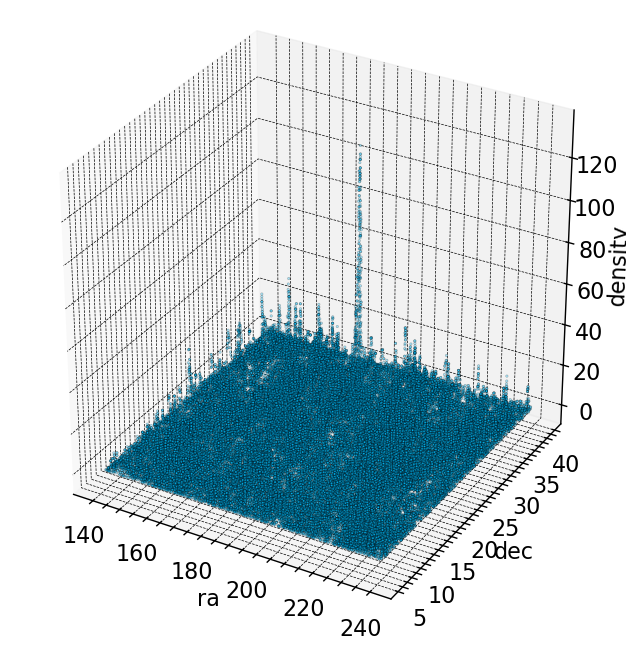

In [33]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'})

ax.set_box_aspect([1, 1, 1])

ax.scatter(data['ra'], data['dec'], tabout['dens_05'], 'o', s=3, edgecolor='black', linewidth=0.4, color='deepskyblue', alpha=0.3)

ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('density')